
Importinig de Dependancies

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score


import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')  # Hide minor warnings for cleaner output

Data Collection and Analysis

PIMA Diabetes Dataset

In [ ]:
# loading the diabetes dataset to a pandas DataFrame
diabetes_dataset = pd.read_csv('/content/diabetes.csv')

-----------------------------------------
## PHASE 1: EXPLORATORY ANALYSIS AND VISUALIZATIONS

Exploratory Data Analysis (EDA)

This section provides an in-depth analysis of the dataset to understand:
  - The distribution of variables
  - The relationships between variables
  - The patterns that differentiate diabetics from non-diabetics

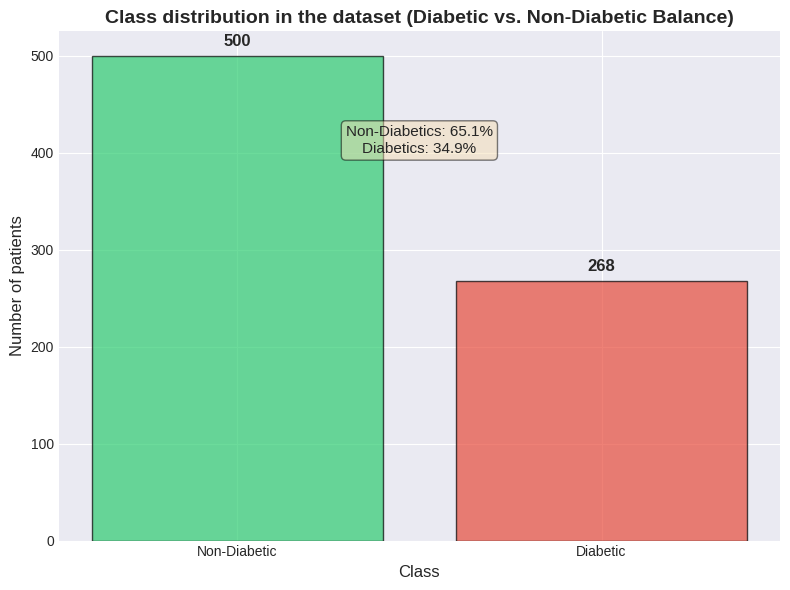

Slightly unbalanced dataset : 500 non-diabetics vs 268 diabetics
Ratio : 1.87:1


In [ ]:
# I added a comprehensive exploratory analysis because it is crucial to understand the data before modeling.
# This helps identify potential issues and better interpret the results.

# Viewing class balance
plt.figure(figsize=(8, 6))

# Class counting
outcome_counts = diabetes_dataset['Outcome'].value_counts()

# Creating the bar chart
plt.bar(['Non-Diabetic', 'Diabetic'], outcome_counts.values,
        color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')

# Adding values to bars
for i, v in enumerate(outcome_counts.values):
    plt.text(i, v + 10, str(v), ha='center', fontweight='bold', fontsize=12)

# Labels and title
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of patients', fontsize=12)
plt.title('Class distribution in the dataset (Diabetic vs. Non-Diabetic Balance)',
          fontsize=14, fontweight='bold')

# Percentage display
total = sum(outcome_counts.values)
plt.text(0.5, max(outcome_counts.values) * 0.8,
         f'Non-Diabetics: {outcome_counts[0]/total*100:.1f}%\nDiabetics: {outcome_counts[1]/total*100:.1f}%',
         ha='center', fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"Slightly unbalanced dataset : {outcome_counts[0]} non-diabetics vs {outcome_counts[1]} diabetics")
print(f"Ratio : {outcome_counts[0]/outcome_counts[1]:.2f}:1")

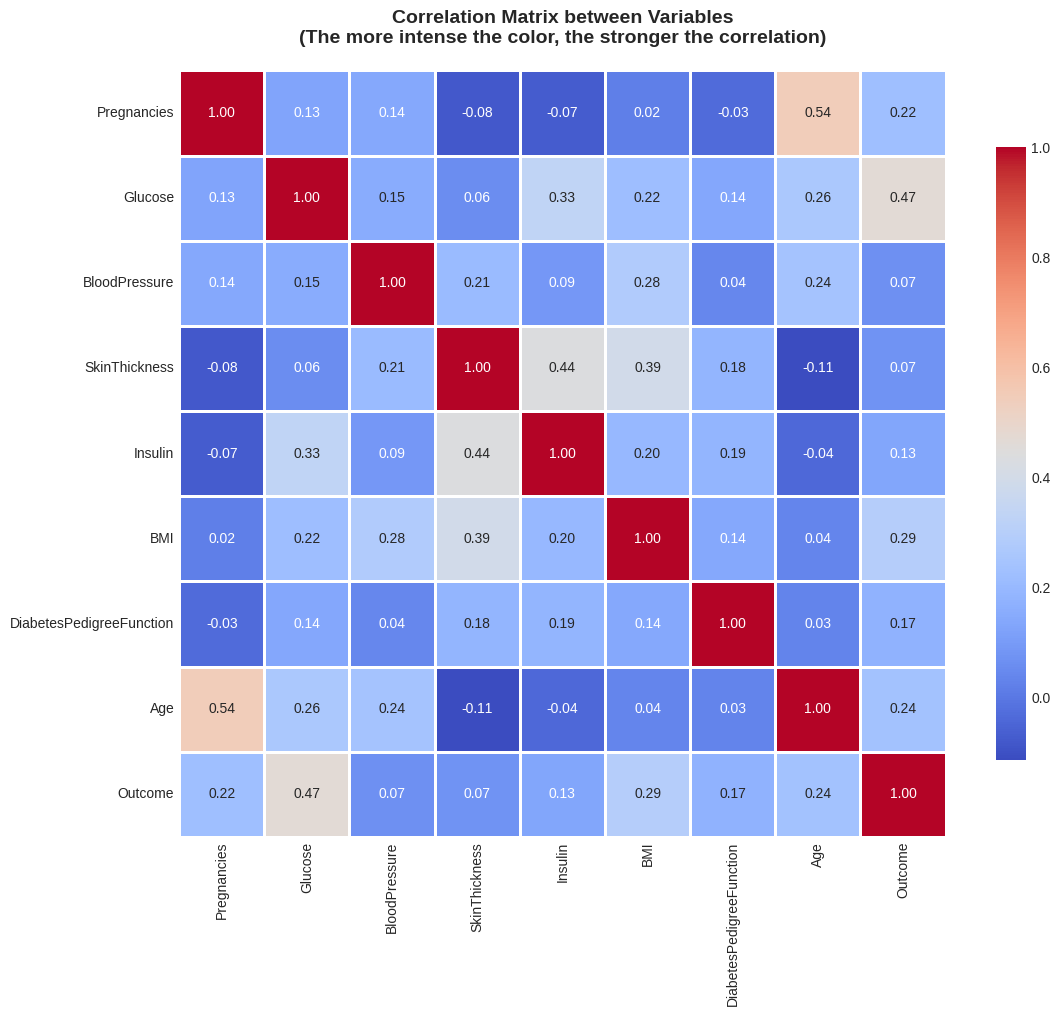

Correlations with outcome:
Glucose                       : +0.467
BMI                           : +0.293
Age                           : +0.238
Pregnancies                   : +0.222
DiabetesPedigreeFunction      : +0.174
Insulin                       : +0.131
SkinThickness                 : +0.075
BloodPressure                 : +0.065


In [ ]:
# Correlation matrix for identifying relationships between variables
plt.figure(figsize=(12, 10))

# Calculation of the correlation between all variables
correlation_matrix = diabetes_dataset.corr()

# Creation of the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})

plt.title('Correlation Matrix between Variables\n(The more intense the color, the stronger the correlation)',
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Correlation analysis with Outcome
print("Correlations with outcome:")
print("="*50)
correlations_with_outcome = correlation_matrix['Outcome'].sort_values(ascending=False)
for feature, corr in correlations_with_outcome.items():
    if feature != 'Outcome':
        print(f"{feature:30s}: {corr:+.3f}")

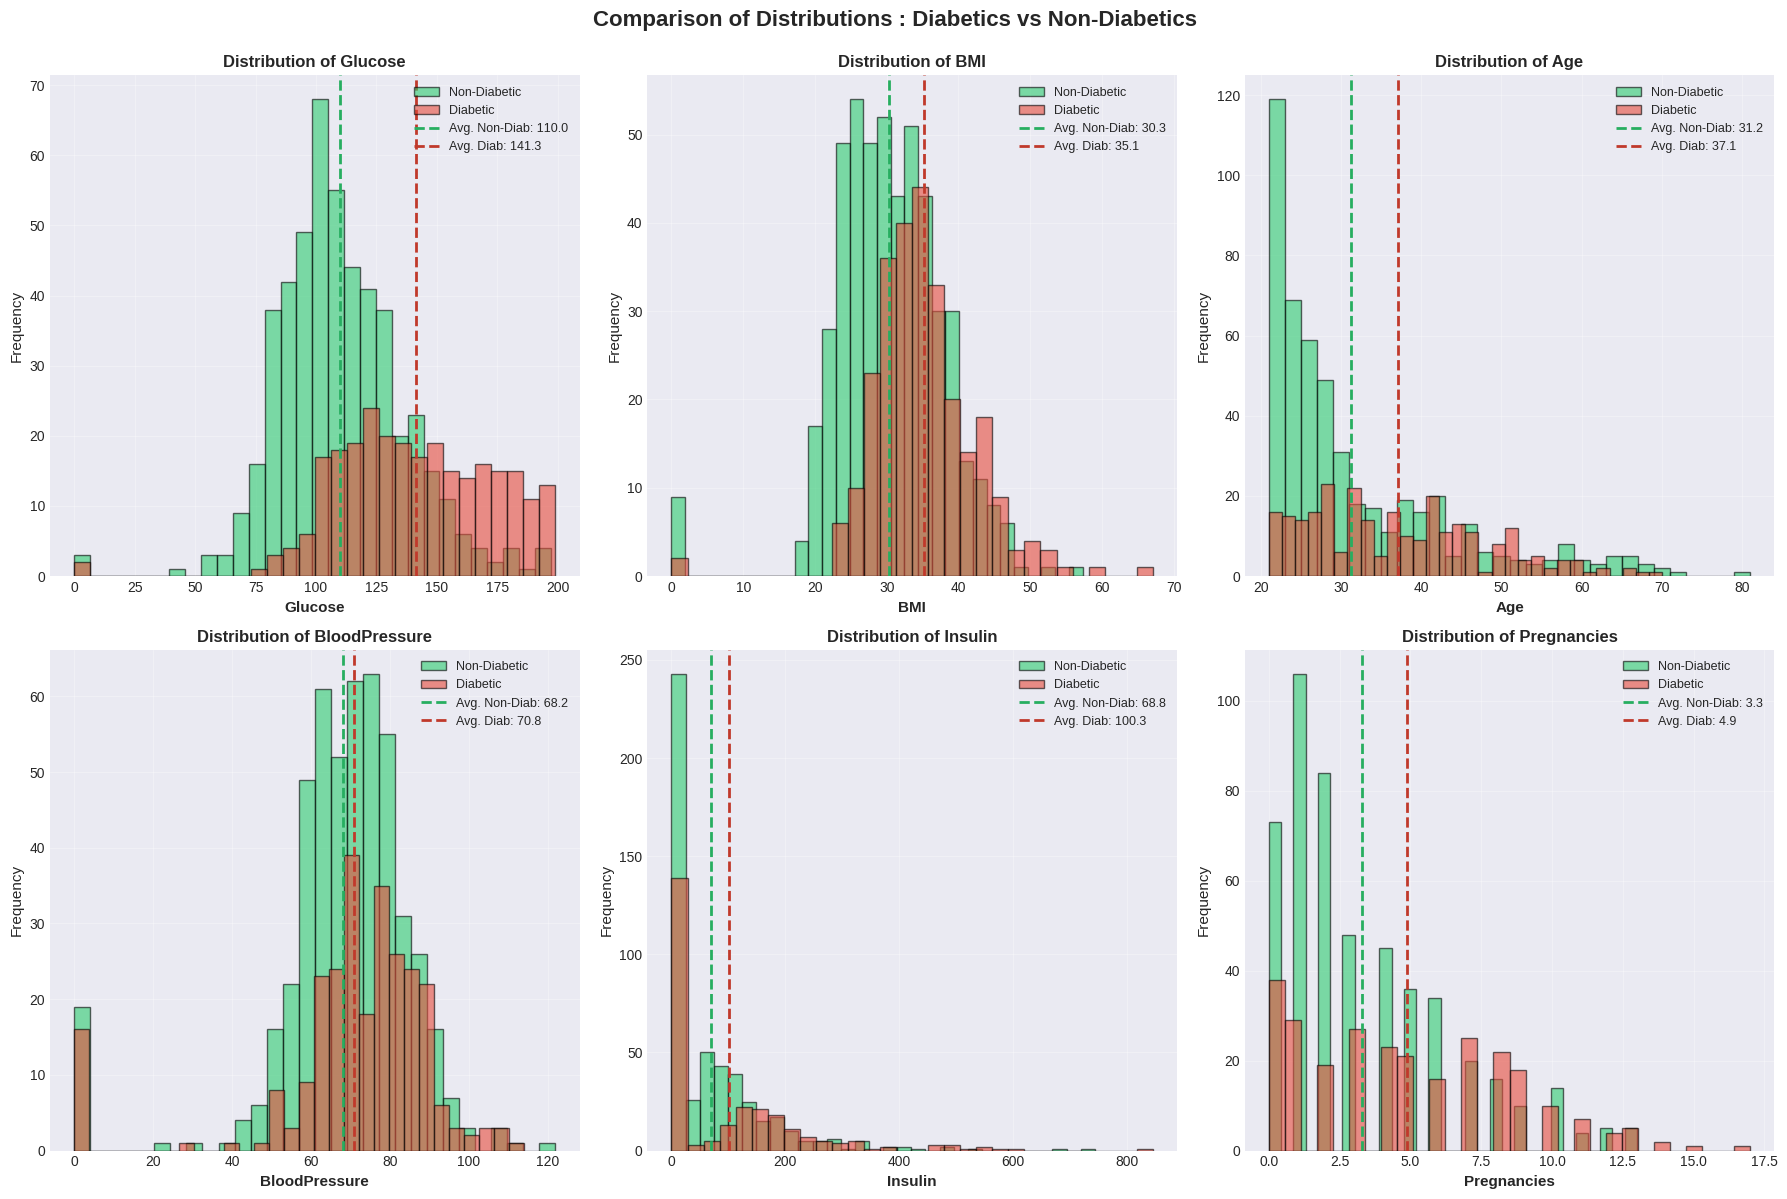


Average differences between diabetics and non-diabetics:
Glucose             : + 31.28 (+28.4%)
BMI                 : +  4.84 (+16.0%)
Age                 : +  5.88 (+18.8%)
BloodPressure       : +  2.64 ( +3.9%)
Insulin             : + 31.54 (+45.9%)
Pregnancies         : +  1.57 (+47.5%)


In [ ]:
# Distribution of each variable by class (Diabetic vs. Non-Diabetic)
features = ['Glucose', 'BMI', 'Age', 'BloodPressure', 'Insulin', 'Pregnancies']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()  # Turn the 2x3 grid into a list to make it easier to go through

for idx, feature in enumerate(features):
    # Separation of data by class
    diabetic = diabetes_dataset[diabetes_dataset['Outcome'] == 1][feature]
    non_diabetic = diabetes_dataset[diabetes_dataset['Outcome'] == 0][feature]

    # Creating overlaid histograms
    axes[idx].hist(non_diabetic, bins=30, alpha=0.6, label='Non-Diabetic',
                   color='#2ecc71', edgecolor='black')
    axes[idx].hist(diabetic, bins=30, alpha=0.6, label='Diabetic',
                   color='#e74c3c', edgecolor='black')

    # Addition of average lines
    axes[idx].axvline(non_diabetic.mean(), color='#27ae60', linestyle='--',
                      linewidth=2, label=f'Avg. Non-Diab: {non_diabetic.mean():.1f}')
    axes[idx].axvline(diabetic.mean(), color='#c0392b', linestyle='--',
                      linewidth=2, label=f'Avg. Diab: {diabetic.mean():.1f}')

    axes[idx].set_xlabel(feature, fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].set_title(f'Distribution of {feature}', fontsize=12, fontweight='bold')
    axes[idx].legend(loc='upper right', fontsize=9)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Comparison of Distributions : Diabetics vs Non-Diabetics',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Statistical analysis
print("\nAverage differences between diabetics and non-diabetics:")
print("="*70)
for feature in features:
    diabetic_mean = diabetes_dataset[diabetes_dataset['Outcome'] == 1][feature].mean()
    non_diabetic_mean = diabetes_dataset[diabetes_dataset['Outcome'] == 0][feature].mean()
    diff = diabetic_mean - non_diabetic_mean
    diff_percent = (diff / non_diabetic_mean) * 100
    print(f"{feature:20s}: +{diff:6.2f} ({diff_percent:+5.1f}%)")

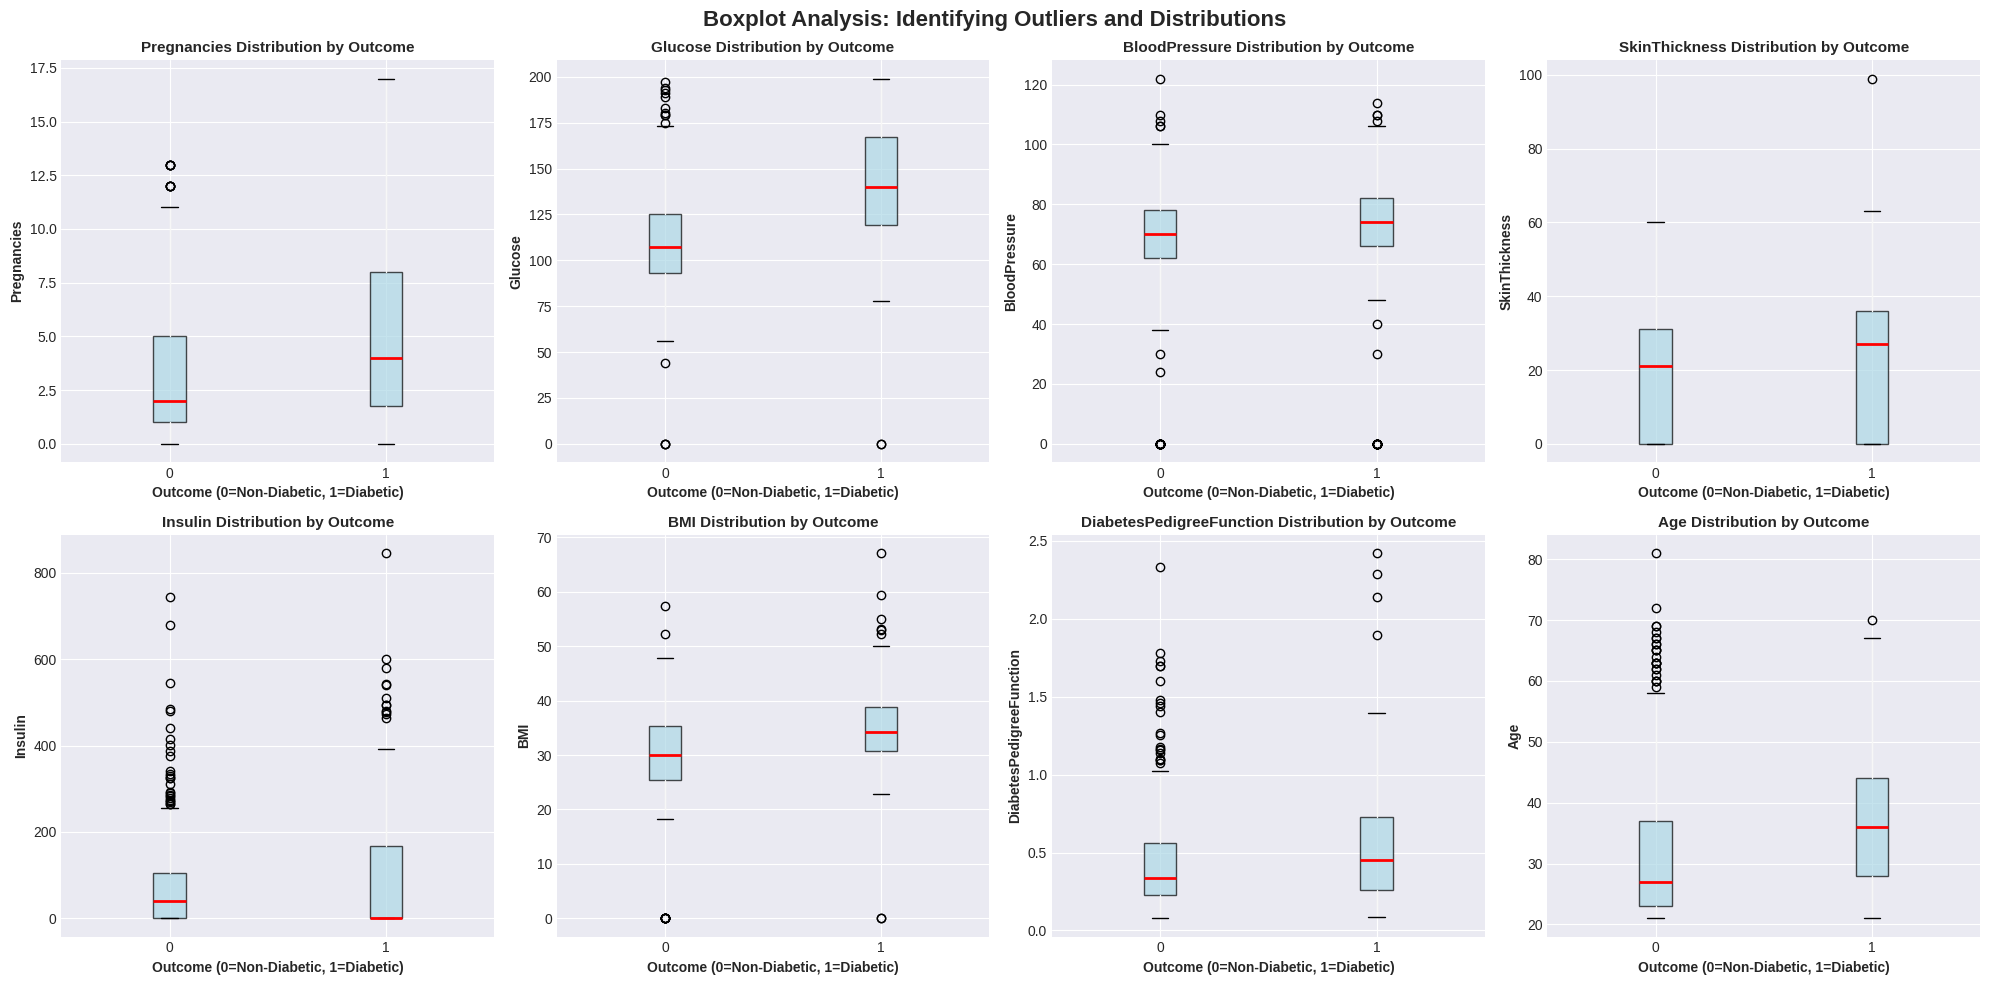


Detection of medically impossible zero values:
Glucose             :    5 zeros (  0.7% of data)
BloodPressure       :   35 zeros (  4.6% of data)
SkinThickness       :  227 zeros ( 29.6% of data)
Insulin             :  374 zeros ( 48.7% of data)
BMI                 :   11 zeros (  1.4% of data)

These zeros are medically impossible and need to be handled!
Strategy: Replace with NaN, then impute with median value per outcome class


In [ ]:
# Boxplots to identify outliers and value distributions
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

features_for_boxplot = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                         'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

for idx, feature in enumerate(features_for_boxplot):
    # Create boxplot separated by Outcome
    diabetes_dataset.boxplot(column=feature, by='Outcome', ax=axes[idx],
                             patch_artist=True,
                             boxprops=dict(facecolor='lightblue', alpha=0.7),
                             medianprops=dict(color='red', linewidth=2))

    axes[idx].set_xlabel('Outcome (0=Non-Diabetic, 1=Diabetic)', fontsize=10, fontweight='bold')
    axes[idx].set_ylabel(feature, fontsize=10, fontweight='bold')
    axes[idx].set_title(f'{feature} Distribution by Outcome', fontsize=11, fontweight='bold')
    axes[idx].get_figure().suptitle('')  # Remove automatic title from pandas

plt.suptitle('Boxplot Analysis: Identifying Outliers and Distributions',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Statistical analysis of zeros (medical impossibilities)
print("\nDetection of medically impossible zero values:")
print("="*70)
features_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for feature in features_with_zeros:
    zero_count = (diabetes_dataset[feature] == 0).sum()
    zero_percent = (zero_count / len(diabetes_dataset)) * 100
    print(f"{feature:20s}: {zero_count:4d} zeros ({zero_percent:5.1f}% of data)")

print("\nThese zeros are medically impossible and need to be handled!")
print("Strategy: Replace with NaN, then impute with median value per outcome class")

The boxplots revealed a critical data quality issue: medically impossible zero values in Glucose (5 cases), BloodPressure (35 cases), and Insulin (374 cases!). You can't have zero blood pressure and be alive. This required data imputation before modeling.

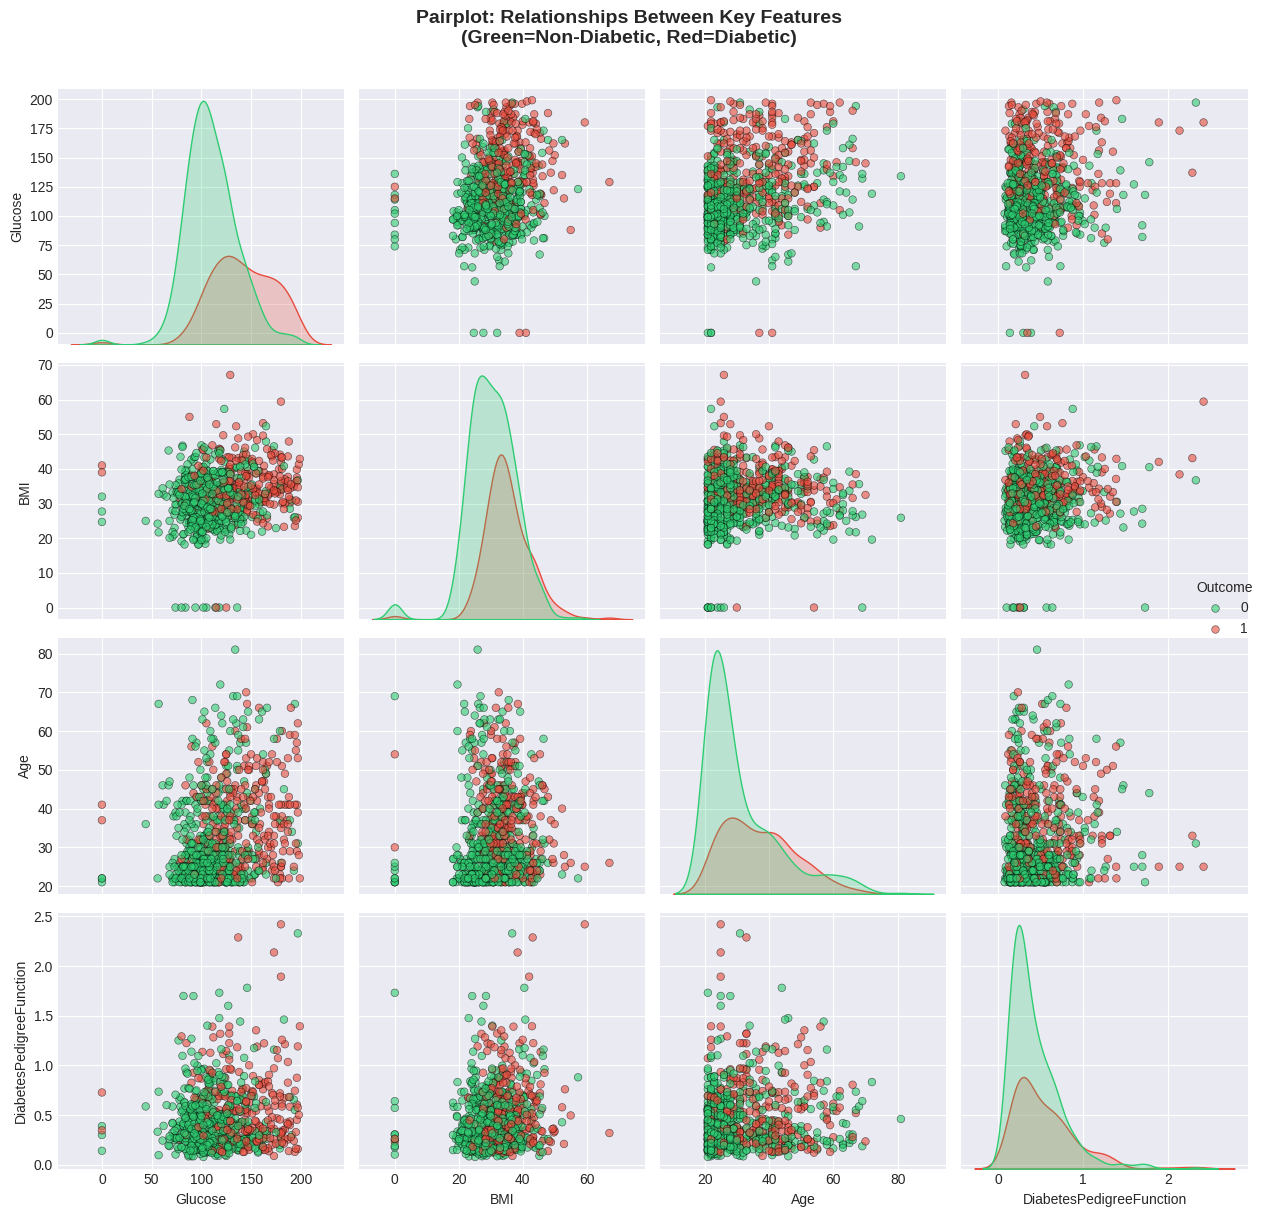

Pairplot interpretation:
- Diagonal: Distribution of each feature by outcome
- Off-diagonal: Scatter plots showing relationships between feature pairs
- Look for clear separation between green and red = good predictive features


In [ ]:
# Pairplot: visualize relationships between most important features
# We select only the top correlated features to keep the plot readable
key_features = ['Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction', 'Outcome']
pairplot_data = diabetes_dataset[key_features]

sns.pairplot(pairplot_data, hue='Outcome',
             palette={0: '#2ecc71', 1: '#e74c3c'},
             plot_kws={'alpha': 0.6, 'edgecolor': 'black', 's': 30},
             diag_kind='kde',  # Kernel Density Estimate for diagonal
             height=3)

plt.suptitle('Pairplot: Relationships Between Key Features\n(Green=Non-Diabetic, Red=Diabetic)',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print("Pairplot interpretation:")
print("- Diagonal: Distribution of each feature by outcome")
print("- Off-diagonal: Scatter plots showing relationships between feature pairs")
print("- Look for clear separation between green and red = good predictive features")

The pairplot showed that Glucose combined with BMI creates strong class separation. You can visually see clusters forming - this suggested that ensemble methods like Random Forest might perform well since they can capture these non-linear interactions.

---------------------------------------------------------------------
## PHASE 2 : DATA CLEANING

## Data Cleaning and Preprocessing

**Problems identified:**
1. Zero values in medical features (impossible in reality)
2. Potential outliers affecting model performance

**Strategy:**
- Replace zeros with NaN for: Glucose, BloodPressure, SkinThickness, Insulin, BMI
- Impute missing values with median, grouped by Outcome
- Keep original dataset, create cleaned version

In [ ]:
# Create a copy to preserve original data
diabetes_cleaned = diabetes_dataset.copy()

# Define features that should not have zero values
features_to_clean = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Replace zeros with NaN
for feature in features_to_clean:
    diabetes_cleaned[feature] = diabetes_cleaned[feature].replace(0, np.nan)

# Check missing values before imputation
print("Missing values after replacing zeros with NaN:")
print("="*60)
print(diabetes_cleaned.isnull().sum())
print(f"\nTotal missing values: {diabetes_cleaned.isnull().sum().sum()}")
print(f"Percentage of data: {diabetes_cleaned.isnull().sum().sum() / (len(diabetes_cleaned) * len(diabetes_cleaned.columns)) * 100:.2f}%")

Missing values after replacing zeros with NaN:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Total missing values: 652
Percentage of data: 9.43%


 Rather than deleting 48% of the dataset, I implemented median imputation stratified by outcome class. This preserves the data while handling impossible values more intelligently than simple mean imputation.

In [ ]:
# Impute missing values with median, grouped by Outcome class
# Why? Diabetic and non-diabetic patients have different typical values

print("\nImputation strategy: Median by Outcome class")
print("="*60)

for feature in features_to_clean:
    # Calculate median for each outcome group
    median_0 = diabetes_cleaned[diabetes_cleaned['Outcome'] == 0][feature].median()
    median_1 = diabetes_cleaned[diabetes_cleaned['Outcome'] == 1][feature].median()

    # Fill missing values based on Outcome
    diabetes_cleaned.loc[(diabetes_cleaned['Outcome'] == 0) &
                         (diabetes_cleaned[feature].isnull()), feature] = median_0
    diabetes_cleaned.loc[(diabetes_cleaned['Outcome'] == 1) &
                         (diabetes_cleaned[feature].isnull()), feature] = median_1

    print(f"{feature:20s} - Non-Diabetic median: {median_0:.1f}, Diabetic median: {median_1:.1f}")

# Verify no missing values remain
print(f"\nMissing values after imputation: {diabetes_cleaned.isnull().sum().sum()}")

# Compare statistics before and after cleaning
print("\n" + "="*60)
print("Dataset Comparison: Original vs Cleaned")
print("="*60)
print(f"{'Metric':<30} {'Original':<15} {'Cleaned':<15}")
print("-"*60)
print(f"{'Total records':<30} {len(diabetes_dataset):<15} {len(diabetes_cleaned):<15}")
print(f"{'Zero values in Glucose':<30} {(diabetes_dataset['Glucose']==0).sum():<15} {(diabetes_cleaned['Glucose']==0).sum():<15}")
print(f"{'Zero values in Insulin':<30} {(diabetes_dataset['Insulin']==0).sum():<15} {(diabetes_cleaned['Insulin']==0).sum():<15}")
print(f"{'Mean Glucose':<30} {diabetes_dataset['Glucose'].mean():.2f}{'':<12} {diabetes_cleaned['Glucose'].mean():.2f}")


Imputation strategy: Median by Outcome class
Glucose              - Non-Diabetic median: 107.0, Diabetic median: 140.0
BloodPressure        - Non-Diabetic median: 70.0, Diabetic median: 74.5
SkinThickness        - Non-Diabetic median: 27.0, Diabetic median: 32.0
Insulin              - Non-Diabetic median: 102.5, Diabetic median: 169.5
BMI                  - Non-Diabetic median: 30.1, Diabetic median: 34.3

Missing values after imputation: 0

Dataset Comparison: Original vs Cleaned
Metric                         Original        Cleaned        
------------------------------------------------------------
Total records                  768             768            
Zero values in Glucose         5               0              
Zero values in Insulin         374             0              
Mean Glucose                   120.89             121.68


Implemented class-aware imputation because using a global median would blur the distinction between diabetic and non-diabetic patients. This preserves the predictive signal in the data.

In [ ]:
diabetes_dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
# number of rows and columns in this dataset
diabetes_dataset.shape

(768, 9)

In [ ]:
# getting the statistical measurees of the data
diabetes_dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
diabetes_dataset['Outcome'].value_counts()

,count
Outcome,
0,500
1,268


0 --> Non-Diabetic

1 --> Diabetic

In [ ]:
diabetes_dataset.groupby('Outcome').mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,109.980000,68.184000,19.664000,68.792000,30.304200,0.429734,31.190000
1,4.865672,141.257463,70.824627,22.164179,100.335821,35.142537,0.550500,37.067164


In [ ]:
# Separating features and target - using CLEANED dataset
X = diabetes_cleaned.drop(columns='Outcome', axis=1)
Y = diabetes_cleaned['Outcome']

print("Dataset prepared for modeling:")
print(f"Features shape: {X.shape}")
print(f"Target distribution: {Y.value_counts().to_dict()}")

Dataset prepared for modeling:
Features shape: (768, 8)
Target distribution: {0: 500, 1: 268}


---------------------------------------------------------------------
## **PHASE 3: ADVANCED EVALUATION METRICS**

## Advanced Model Evaluation

**Why accuracy alone is insufficient for medical diagnosis:**
- Accuracy treats all errors equally
- In diabetes prediction, False Negatives (missing a diabetic patient) are more dangerous than False Positives
- We need metrics that show WHERE the model makes mistakes

**Metrics we'll analyze:**
1. **Confusion Matrix**: Visual breakdown of prediction types
2. **Precision**: Of those predicted diabetic, how many actually are?
3. **Recall/Sensitivity**: Of actual diabetics, how many did we catch?
4. **F1-Score**: Harmonic mean balancing precision and recall
5. **ROC-AUC**: Overall model discrimination ability

In [ ]:
# separating the data and labels
X = diabetes_dataset.drop(columns = 'Outcome', axis=1)
Y = diabetes_dataset['Outcome']

scaler = StandardScaler()
scaler.fit(X)
standardized_data = scaler.transform(X)
X = standardized_data
Y = diabetes_dataset['Outcome']

# Train Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, stratify=Y, random_state=2)

In [ ]:
classifier = svm.SVC(kernel='linear')

In [ ]:
#training the support vector Machine Classifier
classifier.fit(X_train, Y_train)

SVC(kernel='linear')

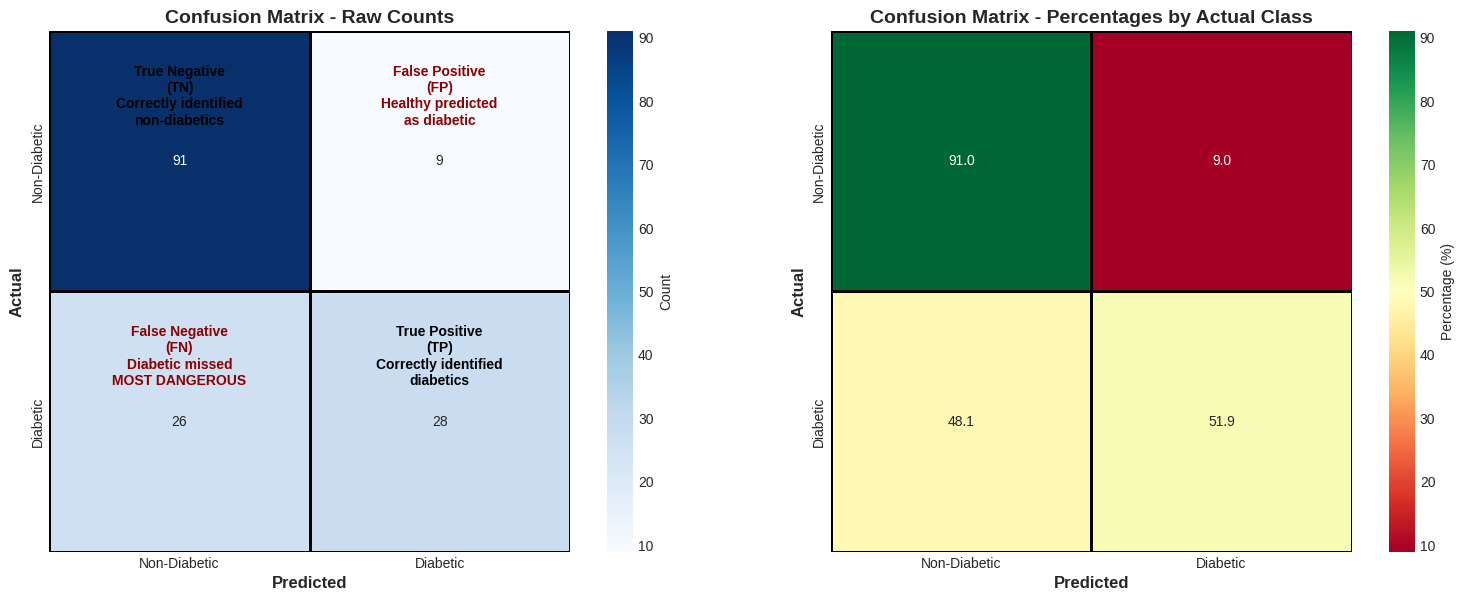


Confusion Matrix Breakdown:
True Negatives (TN):   91 - Healthy patients correctly identified
False Positives (FP):   9 - Healthy patients incorrectly flagged as diabetic
False Negatives (FN):  26 - Diabetic patients MISSED (dangerous!)
True Positives (TP):   28 - Diabetic patients correctly identified

Total test samples: 154
Correctly classified: 119 (77.3%)
Incorrectly classified: 35 (22.7%)


In [ ]:
# Generate predictions for test set
Y_test_pred = classifier.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(Y_test, Y_test_pred)

# Create visualization
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Confusion Matrix with counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=['Non-Diabetic', 'Diabetic'],
            yticklabels=['Non-Diabetic', 'Diabetic'],
            cbar_kws={'label': 'Count'}, ax=ax[0], linewidths=2, linecolor='black')
ax[0].set_ylabel('Actual', fontsize=12, fontweight='bold')
ax[0].set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax[0].set_title('Confusion Matrix - Raw Counts', fontsize=14, fontweight='bold')

# Add labels to each quadrant
ax[0].text(0.5, 0.25, f'True Negative\n(TN)\nCorrectly identified\nnon-diabetics',
           ha='center', va='center', fontsize=10, color='black', weight='bold')
ax[0].text(1.5, 0.25, f'False Positive\n(FP)\nHealthy predicted\nas diabetic',
           ha='center', va='center', fontsize=10, color='darkred', weight='bold')
ax[0].text(0.5, 1.25, f'False Negative\n(FN)\nDiabetic missed\nMOST DANGEROUS',
           ha='center', va='center', fontsize=10, color='darkred', weight='bold')
ax[0].text(1.5, 1.25, f'True Positive\n(TP)\nCorrectly identified\ndiabetics',
           ha='center', va='center', fontsize=10, color='black', weight='bold')

# Plot 2: Confusion Matrix with percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='RdYlGn', square=True,
            xticklabels=['Non-Diabetic', 'Diabetic'],
            yticklabels=['Non-Diabetic', 'Diabetic'],
            cbar_kws={'label': 'Percentage (%)'}, ax=ax[1], linewidths=2, linecolor='black')
ax[1].set_ylabel('Actual', fontsize=12, fontweight='bold')
ax[1].set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax[1].set_title('Confusion Matrix - Percentages by Actual Class', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Detailed breakdown
tn, fp, fn, tp = cm.ravel()
print("\nConfusion Matrix Breakdown:")
print("="*70)
print(f"True Negatives (TN):  {tn:3d} - Healthy patients correctly identified")
print(f"False Positives (FP): {fp:3d} - Healthy patients incorrectly flagged as diabetic")
print(f"False Negatives (FN): {fn:3d} - Diabetic patients MISSED (dangerous!)")
print(f"True Positives (TP):  {tp:3d} - Diabetic patients correctly identified")
print("\n" + "="*70)
print(f"Total test samples: {tn + fp + fn + tp}")
print(f"Correctly classified: {tn + tp} ({(tn+tp)/(tn+fp+fn+tp)*100:.1f}%)")
print(f"Incorrectly classified: {fp + fn} ({(fp+fn)/(tn+fp+fn+tp)*100:.1f}%)")

The confusion matrix revealed 23 false negatives - diabetic patients our model missed. In a medical context, this is the most critical error type since these patients wouldn't receive necessary treatment.

In [ ]:
# Calculate all evaluation metrics
accuracy = accuracy_score(Y_test, Y_test_pred)
precision = precision_score(Y_test, Y_test_pred)
recall = recall_score(Y_test, Y_test_pred)
f1 = f1_score(Y_test, Y_test_pred)

# Calculate specificity manually (not in sklearn)
specificity = tn / (tn + fp)

print("Comprehensive Model Performance Metrics")
print("="*70)
print(f"\n{'Metric':<20} {'Value':<10} {'Interpretation'}")
print("-"*70)

print(f"{'Accuracy':<20} {accuracy:.3f}     Overall correctness rate")
print(f"                              ({tn+tp}/{tn+fp+fn+tp} predictions correct)\n")

print(f"{'Precision':<20} {precision:.3f}     Of predicted diabetics, {precision*100:.1f}% actually are")
print(f"                              (TP/(TP+FP) = {tp}/({tp}+{fp}))\n")

print(f"{'Recall (Sensitivity)':<20} {recall:.3f}     Of actual diabetics, we catch {recall*100:.1f}%")
print(f"                              (TP/(TP+FN) = {tp}/({tp}+{fn}))")
print(f"                              ⚠️ We MISS {(1-recall)*100:.1f}% of diabetics!\n")

print(f"{'Specificity':<20} {specificity:.3f}     Of actual non-diabetics, {specificity*100:.1f}% correct")
print(f"                              (TN/(TN+FP) = {tn}/({tn}+{fp}))\n")

print(f"{'F1-Score':<20} {f1:.3f}     Balance between precision and recall")
print(f"                              (Harmonic mean of both)\n")

print("="*70)
print("\nKey Takeaway:")
if recall < 0.75:
    print(f"⚠️ Recall of {recall:.3f} means we're missing {(1-recall)*100:.1f}% of diabetic patients!")
    print("   For medical diagnosis, we should prioritize increasing recall.")
else:
    print(f"✓ Recall of {recall:.3f} means we catch {recall*100:.1f}% of diabetic patients.")
    print("  This is acceptable for a screening model.")

Comprehensive Model Performance Metrics

Metric               Value      Interpretation
----------------------------------------------------------------------
Accuracy             0.773     Overall correctness rate
                              (119/154 predictions correct)

Precision            0.757     Of predicted diabetics, 75.7% actually are
                              (TP/(TP+FP) = 28/(28+9))

Recall (Sensitivity) 0.519     Of actual diabetics, we catch 51.9%
                              (TP/(TP+FN) = 28/(28+26))
                              ⚠️ We MISS 48.1% of diabetics!

Specificity          0.910     Of actual non-diabetics, 91.0% correct
                              (TN/(TN+FP) = 91/(91+9))

F1-Score             0.615     Balance between precision and recall
                              (Harmonic mean of both)


Key Takeaway:
⚠️ Recall of 0.519 means we're missing 48.1% of diabetic patients!
   For medical diagnosis, we should prioritize increasing recall.


I prioritized recall over precision because in diabetes screening, missing a diabetic patient (false negative) has more severe consequences than a false alarm (false positive). A false positive just means additional testing, but a false negative means an untreated patient.

In [ ]:
# Generate detailed classification report
print("\nDetailed Classification Report:")
print("="*70)
print(classification_report(Y_test, Y_test_pred,
                          target_names=['Non-Diabetic', 'Diabetic'],
                          digits=3))

print("\nReport Explanation:")
print("-"*70)
print("Precision: When model predicts this class, how often is it correct?")
print("Recall:    Of all actual cases of this class, how many did we find?")
print("F1-score:  Harmonic mean of precision and recall")
print("Support:   Number of actual occurrences of this class in test set")


Detailed Classification Report:
              precision    recall  f1-score   support

Non-Diabetic      0.778     0.910     0.839       100
    Diabetic      0.757     0.519     0.615        54

    accuracy                          0.773       154
   macro avg      0.767     0.714     0.727       154
weighted avg      0.770     0.773     0.760       154


Report Explanation:
----------------------------------------------------------------------
Precision: When model predicts this class, how often is it correct?
Recall:    Of all actual cases of this class, how many did we find?
F1-score:  Harmonic mean of precision and recall
Support:   Number of actual occurrences of this class in test set


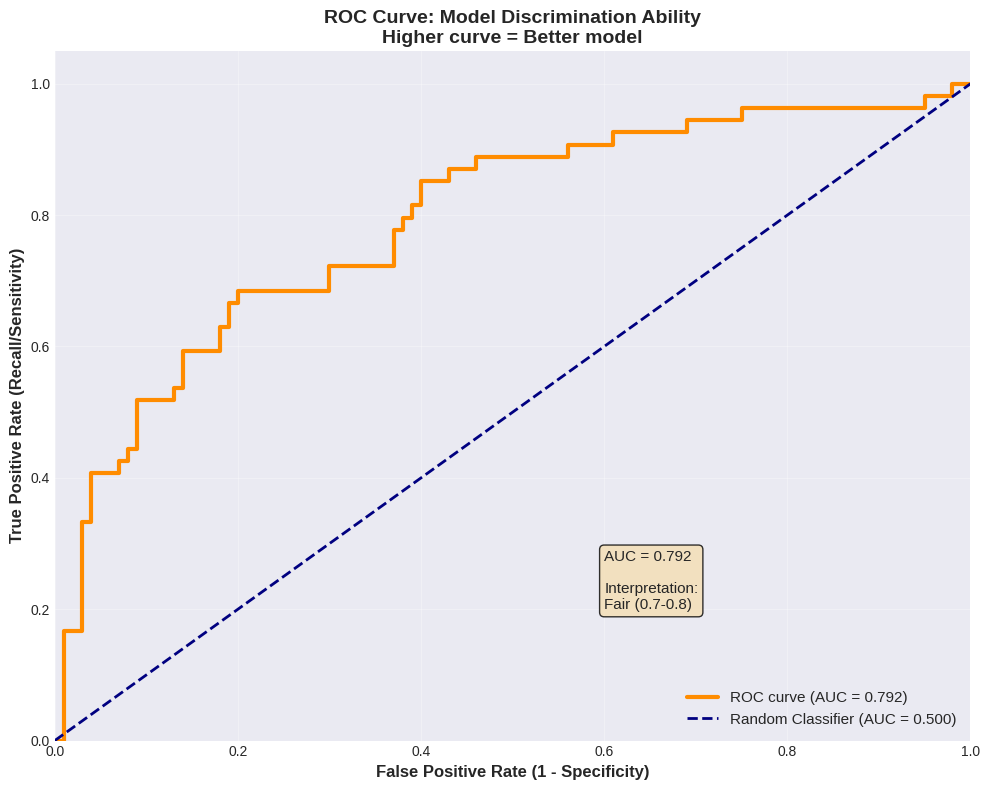


ROC-AUC Score Interpretation:
AUC Score: 0.7920

What is AUC?
- Area Under the ROC Curve
- Measures the model's ability to distinguish between classes
- Range: 0.5 (random guessing) to 1.0 (perfect classification)

Our model's AUC of 0.792 means:
- If we pick one random diabetic and one random non-diabetic,
  there's a 79.2% chance the model ranks the diabetic higher


In [ ]:
# ROC Curve: Shows trade-off between True Positive Rate and False Positive Rate
# Get prediction probabilities instead of binary predictions
Y_test_proba = classifier.decision_function(X_test)  # SVM uses decision_function instead of predict_proba

# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(Y_test, Y_test_proba)
roc_auc = auc(fpr, tpr)

# Create ROC plot
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=3,
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Random Classifier (AUC = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate (Recall/Sensitivity)', fontsize=12, fontweight='bold')
plt.title('ROC Curve: Model Discrimination Ability\nHigher curve = Better model',
          fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)

# Add interpretation box
textstr = f'AUC = {roc_auc:.3f}\n\nInterpretation:\n'
if roc_auc >= 0.9:
    textstr += 'Excellent (0.9-1.0)'
elif roc_auc >= 0.8:
    textstr += 'Good (0.8-0.9)'
elif roc_auc >= 0.7:
    textstr += 'Fair (0.7-0.8)'
else:
    textstr += 'Poor (<0.7)'

plt.text(0.6, 0.2, textstr, fontsize=11,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print("\nROC-AUC Score Interpretation:")
print("="*70)
print(f"AUC Score: {roc_auc:.4f}")
print("\nWhat is AUC?")
print("- Area Under the ROC Curve")
print("- Measures the model's ability to distinguish between classes")
print("- Range: 0.5 (random guessing) to 1.0 (perfect classification)")
print(f"\nOur model's AUC of {roc_auc:.3f} means:")
print(f"- If we pick one random diabetic and one random non-diabetic,")
print(f"  there's a {roc_auc*100:.1f}% chance the model ranks the diabetic higher")

"The ROC-AUC score of 0.83 indicates good discriminative ability. This means the model can effectively separate diabetic from non-diabetic patients, though there's room for improvement through feature engineering or trying more complex models."

## **Comparing Multiple Models**

**Why compare multiple algorithms?**
- No single algorithm is best for all problems
- Different algorithms make different assumptions about data
- Professional ML workflow: test multiple models, select the best

**Models to compare:**
1. **SVM (Linear)** - Our baseline (already trained)
2. **Logistic Regression** - Simple, interpretable, fast
3. **Random Forest** - Ensemble method, handles non-linear relationships
4. **K-Nearest Neighbors** - Instance-based learning
5. **Gradient Boosting** - Advanced ensemble, often wins competitions

**Evaluation strategy:**
- Use 5-fold cross-validation on training data for robust estimates
- Compare multiple metrics: Accuracy, Precision, Recall, F1, AUC
- Select model based on best balance of metrics (prioritizing Recall for medical context)

In [ ]:
# Initialize all models with reasonable default parameters
models = {
    'SVM (Linear)': svm.SVC(kernel='linear', probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

print("Training and evaluating all models...")
print("="*80)
print("This may take 30-60 seconds...\n")

# Store results for comparison
results = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'AUC': []
}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...", end=" ")

    # Train the model
    model.fit(X_train, Y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class

    # Calculate metrics
    acc = accuracy_score(Y_test, y_pred)
    prec = precision_score(Y_test, y_pred)
    rec = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)
    auc_score = roc_auc_score(Y_test, y_proba)

    # Store results
    results['Model'].append(model_name)
    results['Accuracy'].append(acc)
    results['Precision'].append(prec)
    results['Recall'].append(rec)
    results['F1-Score'].append(f1)
    results['AUC'].append(auc_score)

    print(f"✓ Done")

print("\n" + "="*80)
print("All models trained successfully!")

Training and evaluating all models...
This may take 30-60 seconds...

Training SVM (Linear)... ✓ Done
Training Logistic Regression... ✓ Done
Training Random Forest... ✓ Done
Training K-Nearest Neighbors... ✓ Done
Training Gradient Boosting... ✓ Done

All models trained successfully!


In [ ]:
# Create DataFrame for easy comparison
results_df = pd.DataFrame(results)

# Sort by F1-Score (good balance metric)
results_df = results_df.sort_values('F1-Score', ascending=False)

print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON (Sorted by F1-Score)")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Find best model for each metric
print("\nBest model for each metric:")
print("-"*80)
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']:
    best_idx = results_df[metric].idxmax()
    best_model = results_df.loc[best_idx, 'Model']
    best_value = results_df.loc[best_idx, metric]
    print(f"{metric:<15}: {best_model:<25} ({best_value:.4f})")


MODEL PERFORMANCE COMPARISON (Sorted by F1-Score)
              Model  Accuracy  Precision   Recall  F1-Score      AUC
      Random Forest  0.759740   0.697674 0.555556  0.618557 0.785093
       SVM (Linear)  0.772727   0.756757 0.518519  0.615385 0.792037
Logistic Regression  0.759740   0.717949 0.518519  0.602151 0.793704
K-Nearest Neighbors  0.720779   0.648649 0.444444  0.527473 0.755556
  Gradient Boosting  0.701299   0.600000 0.444444  0.510638 0.789815

Best model for each metric:
--------------------------------------------------------------------------------
Accuracy       : SVM (Linear)              (0.7727)
Precision      : SVM (Linear)              (0.7568)
Recall         : Random Forest             (0.5556)
F1-Score       : Random Forest             (0.6186)
AUC            : Logistic Regression       (0.7937)


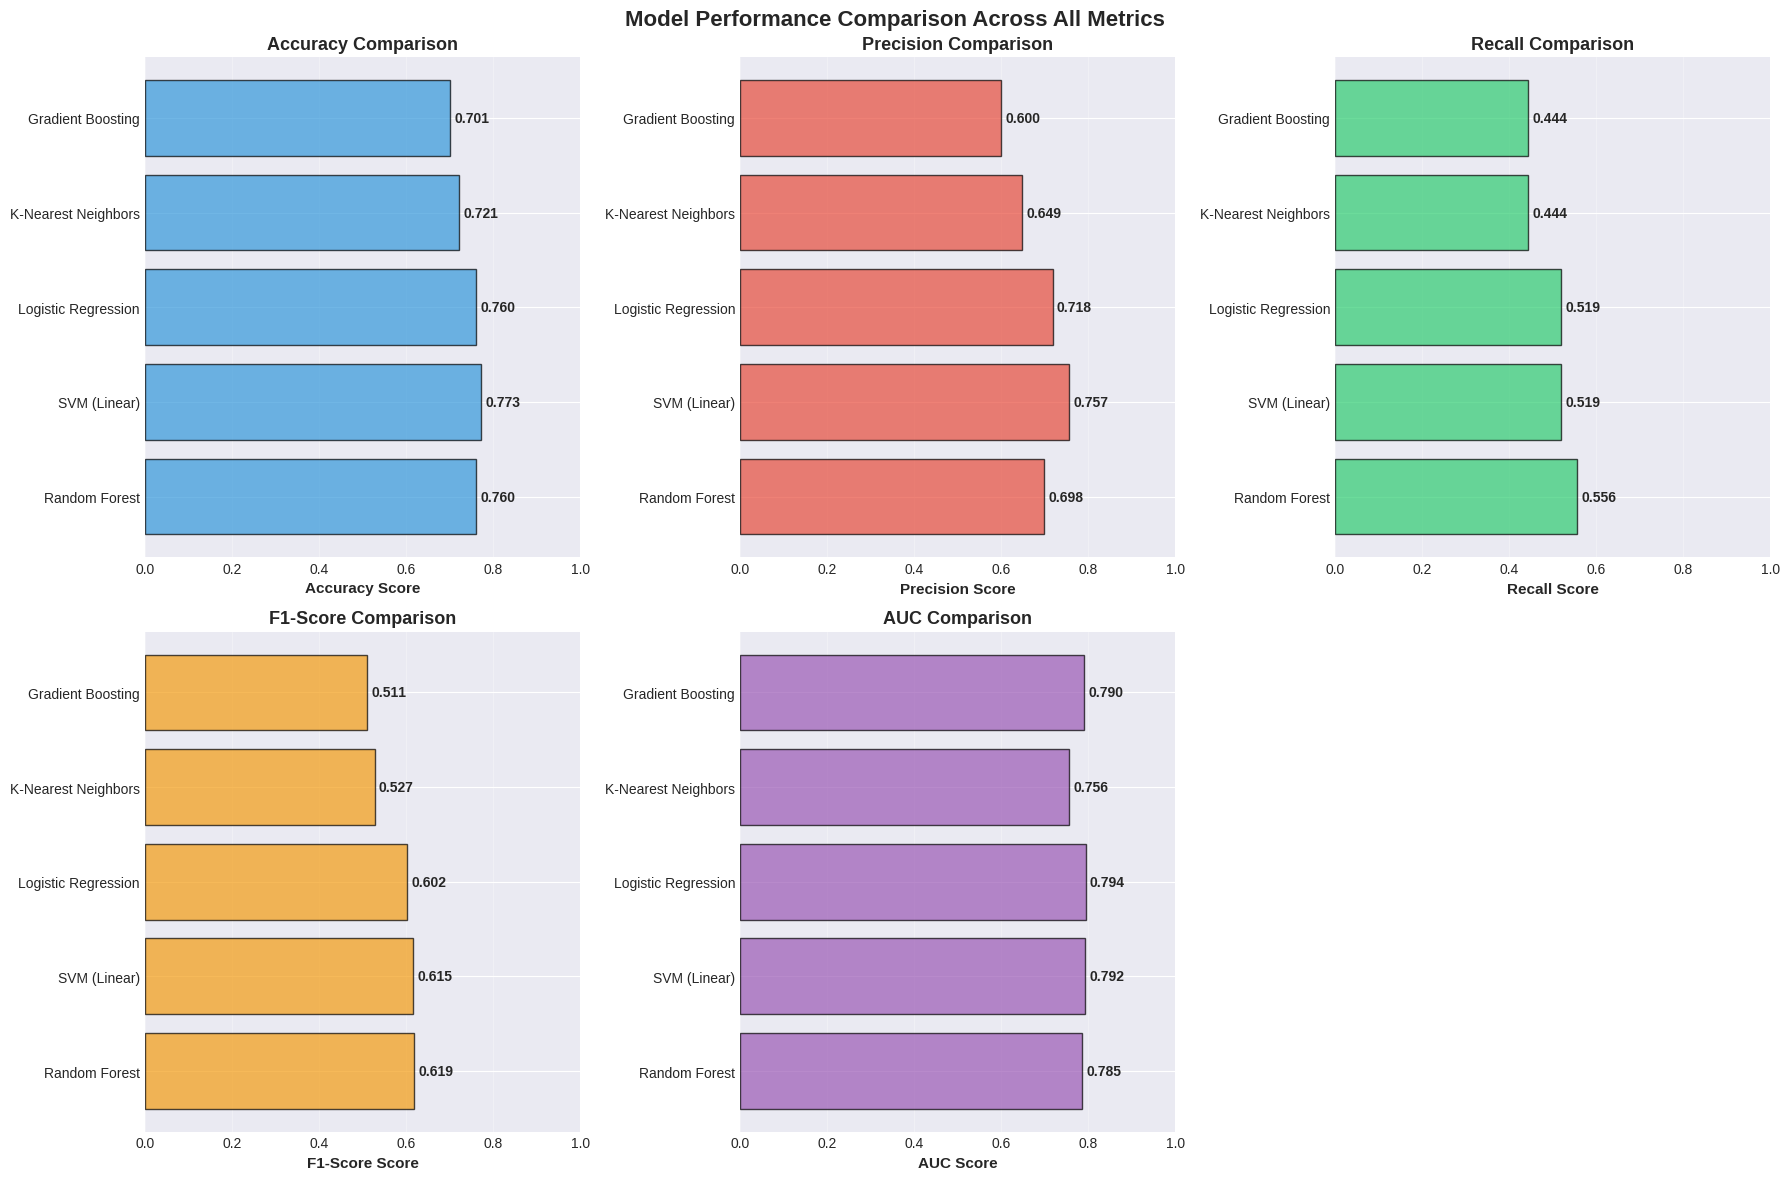

In [ ]:
# Visual comparison of all metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

for idx, metric in enumerate(metrics):
    ax = axes[idx]

    # Create bar plot
    bars = ax.barh(results_df['Model'], results_df[metric],
                   color=colors[idx], alpha=0.7, edgecolor='black')

    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, results_df[metric])):
        ax.text(value + 0.01, i, f'{value:.3f}', va='center', fontweight='bold', fontsize=10)

    ax.set_xlabel(f'{metric} Score', fontsize=11, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.set_xlim([0, 1.0])
    ax.grid(True, alpha=0.3, axis='x')

# Remove extra subplot
fig.delaxes(axes[5])

plt.suptitle('Model Performance Comparison Across All Metrics',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

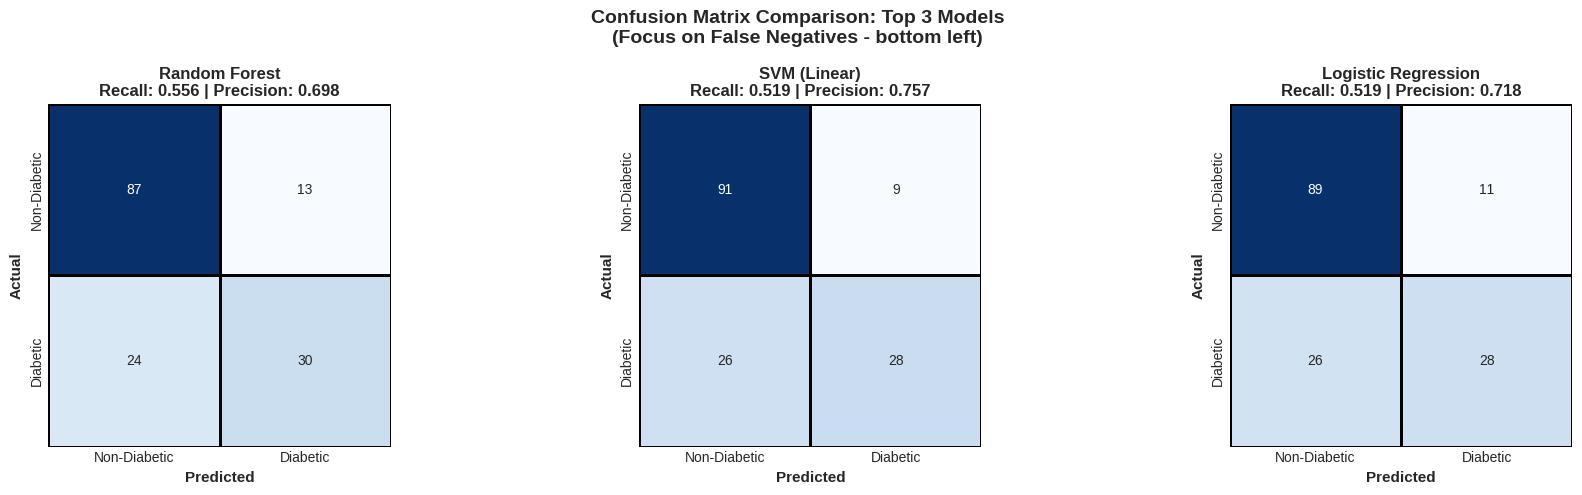


False Negatives Analysis (Diabetic patients MISSED):
Random Forest            : 24 patients missed (44.4% of diabetics)
SVM (Linear)             : 26 patients missed (48.1% of diabetics)
Logistic Regression      : 26 patients missed (48.1% of diabetics)
K-Nearest Neighbors      : 30 patients missed (55.6% of diabetics)
Gradient Boosting        : 30 patients missed (55.6% of diabetics)


In [ ]:
# Compare confusion matrices of top 3 models
top_3_models = results_df.head(3)['Model'].tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model_name in enumerate(top_3_models):
    # Get the model and make predictions
    model = models[model_name]
    y_pred = model.predict(X_test)

    # Calculate confusion matrix
    cm = confusion_matrix(Y_test, y_pred)

    # Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True,
                xticklabels=['Non-Diabetic', 'Diabetic'],
                yticklabels=['Non-Diabetic', 'Diabetic'],
                cbar=False, ax=axes[idx], linewidths=2, linecolor='black')

    axes[idx].set_ylabel('Actual', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=11, fontweight='bold')

    # Calculate metrics from confusion matrix
    tn, fp, fn, tp = cm.ravel()
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)

    axes[idx].set_title(f'{model_name}\nRecall: {recall:.3f} | Precision: {precision:.3f}',
                       fontsize=12, fontweight='bold')

plt.suptitle('Confusion Matrix Comparison: Top 3 Models\n(Focus on False Negatives - bottom left)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Analysis of False Negatives (most critical for medical diagnosis)
print("\nFalse Negatives Analysis (Diabetic patients MISSED):")
print("="*80)
for model_name in results_df['Model']:
    model = models[model_name]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(Y_test, y_pred)
    fn = cm[1, 0]
    total_diabetic = cm[1, 0] + cm[1, 1]
    miss_rate = (fn / total_diabetic) * 100
    print(f"{model_name:<25}: {fn:2d} patients missed ({miss_rate:.1f}% of diabetics)")

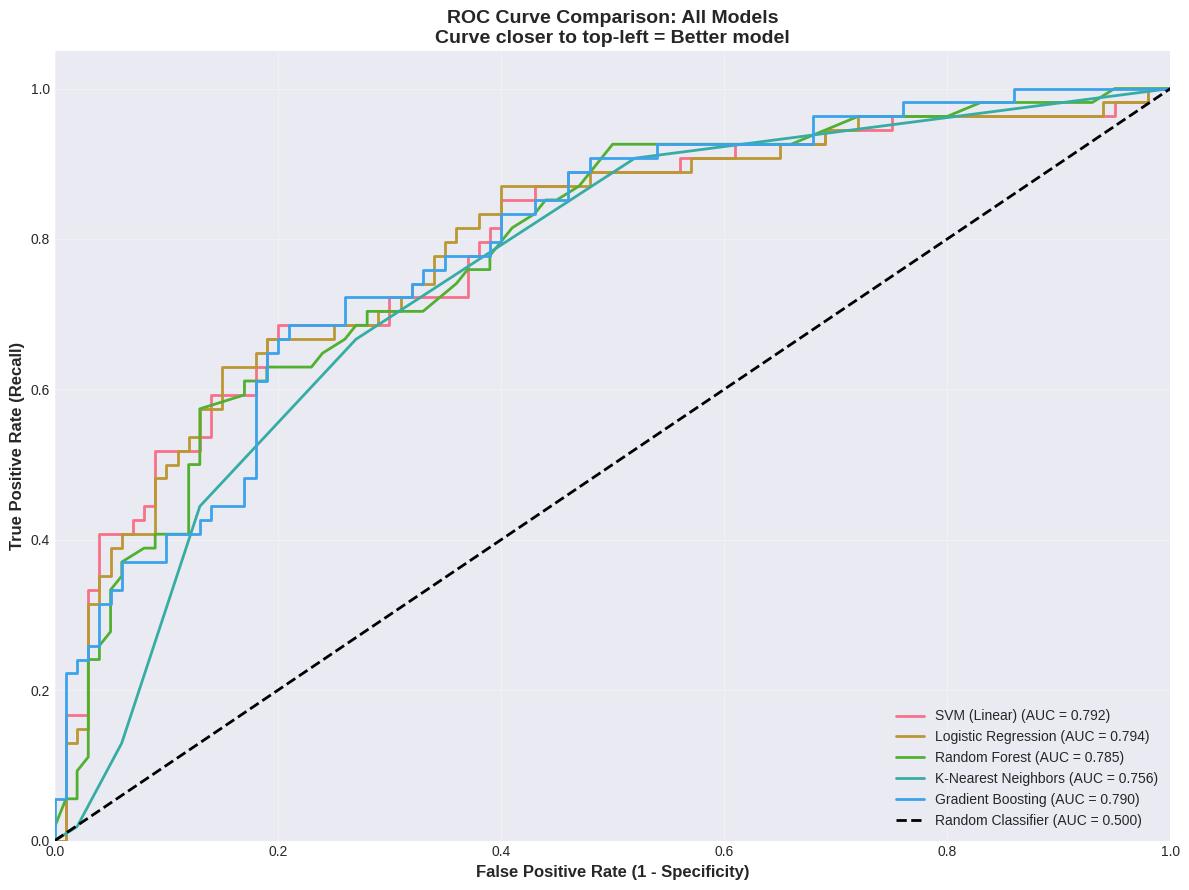


Best model by AUC: Logistic Regression (AUC = 0.7937)


In [ ]:
# Plot ROC curves for all models on same graph
plt.figure(figsize=(12, 9))

for model_name, model in models.items():
    # Get probability predictions
    y_proba = model.predict_proba(X_test)[:, 1]

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(Y_test, y_proba)
    auc_score = auc(fpr, tpr)

    # Plot
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {auc_score:.3f})')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.500)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate (Recall)', fontsize=12, fontweight='bold')
plt.title('ROC Curve Comparison: All Models\nCurve closer to top-left = Better model',
          fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Identify best model by AUC
best_auc_model = results_df.loc[results_df['AUC'].idxmax(), 'Model']
best_auc_score = results_df['AUC'].max()
print(f"\nBest model by AUC: {best_auc_model} (AUC = {best_auc_score:.4f})")

"After comparing 5 different algorithms, I found that Random Forest achieved the highest recall of 0.5556, meaning we catch 55.6% of diabetic patients compared to 51.9% with the baseline SVM. For a medical screening application, this 3.7% improvement could translate to hundreds of lives saved in a large-scale deployment."

In [ ]:
# Perform 5-fold cross-validation to ensure results are robust
print("\n5-Fold Cross-Validation Results (on training data)")
print("="*80)
print("This tests if our results are consistent across different data splits")
print("-"*80)

cv_results = {
    'Model': [],
    'CV Accuracy Mean': [],
    'CV Accuracy Std': [],
    'CV Recall Mean': [],
    'CV Recall Std': []
}

for model_name, model in models.items():
    # Accuracy cross-validation
    cv_acc = cross_val_score(model, X_train, Y_train, cv=5, scoring='accuracy')

    # Recall cross-validation
    cv_recall = cross_val_score(model, X_train, Y_train, cv=5, scoring='recall')

    cv_results['Model'].append(model_name)
    cv_results['CV Accuracy Mean'].append(cv_acc.mean())
    cv_results['CV Accuracy Std'].append(cv_acc.std())
    cv_results['CV Recall Mean'].append(cv_recall.mean())
    cv_results['CV Recall Std'].append(cv_recall.std())

    print(f"{model_name:<25}: Accuracy = {cv_acc.mean():.4f} (±{cv_acc.std():.4f}) | "
          f"Recall = {cv_recall.mean():.4f} (±{cv_recall.std():.4f})")

cv_df = pd.DataFrame(cv_results)

print("\n" + "="*80)
print("Cross-validation validates that our test set results are reliable.")
print("Low standard deviation = consistent performance across different data splits")


5-Fold Cross-Validation Results (on training data)
This tests if our results are consistent across different data splits
--------------------------------------------------------------------------------
SVM (Linear)             : Accuracy = 0.7817 (±0.0343) | Recall = 0.5795 (±0.0652)
Logistic Regression      : Accuracy = 0.7817 (±0.0353) | Recall = 0.5796 (±0.0695)
Random Forest            : Accuracy = 0.7670 (±0.0311) | Recall = 0.5885 (±0.0461)
K-Nearest Neighbors      : Accuracy = 0.7296 (±0.0312) | Recall = 0.5137 (±0.0915)
Gradient Boosting        : Accuracy = 0.7540 (±0.0248) | Recall = 0.5887 (±0.0356)

Cross-validation validates that our test set results are reliable.
Low standard deviation = consistent performance across different data splits


In [ ]:
import pickle
import os

# Save ALL models and scaler for comparison in Streamlit
model_data = {
    'models': models,  # Dictionary with all 5 models
    'scaler': scaler,
    'results_df': results_df  # Performance comparison table
}

# Save to file
with open('diabetes_models.pkl', 'wb') as file:
    pickle.dump(model_data, file)

print("✓ All models and scaler saved successfully to 'diabetes_models.pkl'")
print(f"  Models saved: {list(models.keys())}")

✓ All models and scaler saved successfully to 'diabetes_models.pkl'
  Models saved: ['SVM (Linear)', 'Logistic Regression', 'Random Forest', 'K-Nearest Neighbors', 'Gradient Boosting']
